# Preferential Bayesian Optimization: Multinomial Predictive Entropy Search

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
gpu_to_use = 2

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[gpu_to_use], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  4
4 Physical GPUs, 1 Logical GPU


In [3]:
features = pickle.load( open( "sushi_features.p", "rb" ) )

In [4]:
fvals = pickle.load( open( "fvals.p", "rb" ) )

In [5]:
# construct dict
feat_to_fval_dict = {}
for i in range(len(features)):
    key = features[i].data.tobytes()
    feat_to_fval_dict[key] = fvals[i]

In [6]:
objective = lambda x: PBO.objectives.sushi(x, feat_to_fval_dict)
objective_low = np.min(features)
objective_high = np.max(features)
objective_name = "SUSHI"
acquisition_name = "MPES"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name + "_" + "v1"

In [7]:
num_runs = 1
num_evals = 35
num_choices = 2
input_dims = 6
num_maximizers = 20
num_maximizers_init = 50
num_fourier_features = 1000
num_init_prefs = 6 

In [8]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /temp/sebtaysh/PBO/notebooks/SUSHI/results/PBO_MPES_SUSHIv1/  created 


In [9]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [10]:
def train_and_visualize(X, y, title, lengthscale_init=None, signal_variance_init=None):
    
    # Train model with data
    result = PBO.models.learning_fullgp.train_model_fullcov(
                        X, y, 
                        obj_low=objective_low,
                        obj_high=objective_high,
                        lengthscale_init=lengthscale_init,
                        signal_variance_init=signal_variance_init,
                        indifference_threshold=0.,
                        n_sample=1000,
                        deterministic=True, # only sample f values once, not re-sampling
                        num_steps=3000)
    
    q_mu = result['q_mu']
    q_sqrt = result['q_sqrt']
    u = result['u']
    inputs = result['inputs']
    k = result['kernel']
    
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    return model, inputs, u_mean, inducing_vars

Generate rank dictionary and immediate regret dictionary.

In [11]:
fval_idx_tuples = pickle.load(open("fval_idx_tuples.p", "rb"))

In [12]:
rank_dict = {}

for i in range(len(fval_idx_tuples)):
    rank_dict[features[fval_idx_tuples[i][1]].data.tobytes()] = i + 1

This function is our main metric for the performance of the acquisition function.

In [13]:
def get_max_sushi(model, features, rank_dict):
    """
    :param model: gpflow model
    :param features: sushi features
    :param rank_dict: dictionary from sushi idx to place in ranking
    :return: tuple (index of max sushi, rank)
    """
    f_preds = model.predict_f(features)[0]
    max_idx = np.argmax(f_preds)
    
    return (max_idx, rank_dict[features[max_idx].data.tobytes()])

Store the results in these arrays:

In [14]:
num_data_at_end = int(num_init_prefs + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
immediate_regret = np.zeros([num_runs, num_evals], np.int32)

Create the initial values for each run:

In [15]:
np.random.seed(0)
random_indices = np.random.choice(features.shape[0], [num_runs, num_init_prefs, num_choices])
init_vals = np.take(features, random_indices, axis=0)

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

In [16]:
for run in range(num_runs):  # CHECK IF STARTING RUN IS CORRECT
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 
        
        success = False
        fail_count = 0
        while not success:
            # TODO: THIS ONLY WORKS FOR TOP-1 OF 2, CHANGE TO APPROPRIATE QUERY SAMPLING FOR HIGHER NUMBER OF CHOICES
            samples = PBO.models.learning_fullgp.construct_input_pairs(inputs, features)

            # Sample maximizers
            print("Evaluation %s: Sampling maximizers" % (evaluation))
            maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars,
                                                                count=num_maximizers,
                                                                n_init=num_maximizers_init,
                                                                D=num_fourier_features,
                                                                model=model,
                                                                min_val=objective_low,
                                                                max_val=objective_high)
            print(maximizers)

            # Calculate PES value I for each possible next query
            print("Evaluation %s: Calculating I" % (evaluation))
            I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

            # Select query that maximizes I
            next_idx = np.argmax(I_vals)
            next_query = samples[next_idx]
            print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

            X_temp = np.concatenate([X, [next_query]])
            # Evaluate objective function
            y_temp = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
            
            try:
                print("Evaluation %s: Training model" % (evaluation))
                model, inputs, u_mean, inducing_vars = train_and_visualize(X_temp, y_temp,
                                                                           "Run_{}_Evaluation_{}".format(run, evaluation))
                success = True

            except ValueError as err:
                print(err)
                print("Retrying sampling random inputs")
                fail_count += 1

            if fail_count >= 10:
                print("Retry limit exceeded")
                raise ValueError("Failed")
                
        
        X = X_temp
        y = y_temp
        
        # Save model
        pickle.dump((X, y, inputs, 
                     model.kernel.variance, 
                     model.kernel.lengthscale, 
                     model.likelihood.variance, 
                     inducing_vars, 
                     model.q_mu, 
                     model.q_sqrt, 
                     maximizers), 
                    open(results_dir + "Model_Run_{}_Evaluation_{}.p".format(run, evaluation), "wb"))

        (max_idx, rank) = get_max_sushi(model, features, rank_dict)
        immediate_regret[run, evaluation] = rank - 1
        
        print("Maximizing sushi has index {} and rank {}".format(max_idx, rank)) 

    X_results[run] = X
    y_results[run] = y

Beginning run 0
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.5 0.5 0.5 0.5 0.5 0.5]
       signal variance at 1.0
   Initial negative ELBO: 86.35006495121657
Negative ELBO at step 0: 85.64465871521675 in 6.8182s
Negative ELBO at step 500: 10.381084749587544 in 338.1304s
Negative ELBO at step 1000: 9.90373833397229 in 27.7044s
Negative ELBO at step 1500: 9.688077410231983 in 27.7024s
Negative ELBO at step 2000: 9.509749322435834 in 27.6450s
Negative ELBO at step 2500: 9.382295684743234 in 27.6648s
Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: 0.16768965688325665
Loss at step 500: -1.8613015718635781
Loss at step 1000: -2.307416044299729
Loss at step 1500: -2.35517405990322
Loss at step 2000: -2.3587347891992145
Loss at step 2500: -2.3597670226050975
Loss at step 2788: -2.359905683650006
test.shape

Evaluation 2: Next query is tf.Tensor(
[[1.         0.         0.44238976 0.78283547 0.25096426 0.88      ]
 [1.         0.         0.49253731 0.14427861 0.57381325 0.04      ]], shape=(2, 6), dtype=float64) with I value of 0.06331139803725672
Evaluation 2: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.5 0.5 0.5 0.5 0.5 0.5]
       signal variance at 1.0
   Initial negative ELBO: 194.43926817132453
Negative ELBO at step 0: 192.78985945589451 in 0.1208s
Negative ELBO at step 500: 12.748368281996225 in 48.2352s
Negative ELBO at step 1000: 11.846123456001026 in 53.8637s
Negative ELBO at step 1500: 11.610498283567967 in 72.7467s
Negative ELBO at step 2000: 11.440495832458547 in 60.0544s
Negative ELBO at step 2500: 11.313624340153833 in 57.3774s
Maximizing sushi has index 79 and rank 9
Beginning evaluation 3
Evalu

Evaluation 5: Next query is tf.Tensor(
[[1.         0.         0.67008197 0.43169399 0.69292297 0.2       ]
 [1.         0.         0.19879833 0.67816092 0.62188977 0.56      ]], shape=(2, 6), dtype=float64) with I value of 0.06796842532338995
Evaluation 5: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.5 0.5 0.5 0.5 0.5 0.5]
       signal variance at 1.0
   Initial negative ELBO: 327.92001907447184
Negative ELBO at step 0: 324.57283299474386 in 0.1530s
Negative ELBO at step 500: 14.586912907370749 in 47.8410s
Negative ELBO at step 1000: 13.389173646743899 in 48.1767s
Negative ELBO at step 1500: 13.02145040530929 in 48.3687s
Negative ELBO at step 2000: 12.790416226829555 in 48.0305s
Negative ELBO at step 2500: 12.617360151027425 in 47.9241s
Maximizing sushi has index 79 and rank 9
Beginning evaluation 6
Evalua

Negative ELBO at step 500: 16.886606857906532 in 54.7508s
Negative ELBO at step 1000: 15.11816223636085 in 56.5941s
Negative ELBO at step 1500: 14.621557722817906 in 55.4905s
Negative ELBO at step 2000: 14.295892778772254 in 55.6247s
Negative ELBO at step 2500: 14.131001556344286 in 54.6141s
Maximizing sushi has index 21 and rank 26
Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: -0.13784270504771443
Loss at step 500: -2.286789939073326
Loss at step 1000: -2.564240697991276
Loss at step 1500: -2.578000754767139
Loss at step 1576: -2.578369593995593
test.shape =  (20, 50, 1)
tf.Tensor(
[[8.35562803e-01 2.23929922e-03 1.24176329e-01 7.06317077e-01
  6.23923288e-01 4.14304165e-01]
 [1.00000000e+00 0.00000000e+00 5.08696235e-01 6.22650467e-01
  2.93617101e-01 4.69314342e-01]
 [9.86488594e-01 0.00000000e+00 7.80991365e-01 6.03648567e-01
  3.81404528e-01 8.93849326e-01]
 [8.25865675e-01 3.08896794e-03 6.98310744e-01 4.37676115e-01
  3.23101848e-01 3.96857208e-01]
 [1

Negative ELBO at step 0: 667.1902814815172 in 0.2083s
Negative ELBO at step 500: 19.369765994026206 in 63.9936s
Negative ELBO at step 1000: 17.113506961022374 in 64.0710s
Negative ELBO at step 1500: 16.32665766487794 in 102.9541s
Negative ELBO at step 2000: 15.92086639419654 in 139.8532s
Negative ELBO at step 2500: 15.713005218185046 in 178.2853s
Maximizing sushi has index 11 and rank 14
Beginning evaluation 12
Evaluation 12: Sampling maximizers
Loss at step 0: -0.07726492506382271
Loss at step 500: -2.504825872925062
Loss at step 1000: -2.81157326604236
Loss at step 1500: -2.842280968391222
Loss at step 2000: -2.846165269153618
Loss at step 2500: -2.848373186022214
Loss at step 2507: -2.848383101866384
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.99517005 0.         0.71410519 0.54887753 0.34588148 0.64835636]
 [0.95969989 0.01153834 0.59918693 0.55338825 0.38735702 0.64757772]
 [0.55918658 0.         0.79222649 0.46483827 0.36177175 0.46361591]
 [0.86258529 0.01576258 0.75563791 0.530386

Negative ELBO at step 500: 21.69196774546422 in 195.1693s
Negative ELBO at step 1000: 18.86990991649953 in 201.7557s
Negative ELBO at step 1500: 18.19454731902767 in 196.9955s
Negative ELBO at step 2000: 17.772004631385148 in 188.4259s
Negative ELBO at step 2500: 17.53727551395326 in 188.3521s
Maximizing sushi has index 11 and rank 14
Beginning evaluation 15
Evaluation 15: Sampling maximizers
Loss at step 0: -0.09877760963465766
Loss at step 500: -2.2824891573545045
Loss at step 1000: -2.4526968192519316
Loss at step 1500: -2.4679932464523184
Loss at step 1686: -2.4684425918417845
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.96688219 0.         0.30848326 0.58509433 0.39104526 0.47224778]
 [0.9406698  0.         0.22778961 0.55865693 0.41307931 0.66403394]
 [0.80697762 0.21540046 0.68218668 0.57994211 0.37199268 0.79959583]
 [0.92278575 0.07711378 0.51859188 0.54162452 0.41112238 0.57600174]
 [0.81608087 0.4079109  0.11565601 0.64375683 0.40504481 0.80079749]
 [0.92320467 0.         0.6751

Negative ELBO at step 1500: 20.01130822914285 in 220.4661s
Negative ELBO at step 2000: 19.454992696110274 in 202.9448s
Negative ELBO at step 2500: 19.027285386994823 in 192.6028s
Maximizing sushi has index 11 and rank 14
Beginning evaluation 18
Evaluation 18: Sampling maximizers
Loss at step 0: -0.01011371466508757
Loss at step 500: -2.284886936510495
Loss at step 1000: -2.452787626146355
Loss at step 1500: -2.4674765041038103
Loss at step 1657: -2.4678924459659246
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.89825945 0.         0.29852266 0.59814585 0.31618699 0.95030027]
 [1.         0.         0.         0.56968561 0.40666153 0.02134962]
 [1.         0.05732868 0.55571131 0.51254149 0.48664707 0.        ]
 [0.50542243 0.         0.53202077 0.57550157 0.38078946 0.93255002]
 [1.         0.         0.         0.7172332  0.63897309 0.42454364]
 [1.         0.09299561 1.         0.55839301 0.32637092 0.53926443]
 [1.         0.         0.35666784 0.56133855 0.35138528 0.39260703]
 [0.661103

Negative ELBO at step 2000: 21.194100928534617 in 232.3585s
Negative ELBO at step 2500: 20.760906286252833 in 216.9076s
Maximizing sushi has index 11 and rank 14
Beginning evaluation 21
Evaluation 21: Sampling maximizers
Loss at step 0: -0.020829459075182563
Loss at step 500: -1.4349214218684911
Loss at step 1000: -1.5589704478633826
Loss at step 1500: -1.5860110968121284
Loss at step 2000: -1.5907642233255797
Loss at step 2136: -1.5908878202014443
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.99857202 0.         0.         0.68426794 0.35842804 0.43855606]
 [0.99384114 0.         0.44137813 0.48641224 0.36347988 1.        ]
 [1.         0.10862387 0.         0.57876946 0.30656908 0.54475662]
 [1.         0.         0.         0.59256625 0.35378477 0.74075715]
 [0.99532223 0.15388428 1.         0.64057688 0.37029655 1.        ]
 [1.         0.05394556 1.         0.57167326 0.38392215 0.52091727]
 [1.         0.25343967 0.61177573 0.33535496 0.7597682  0.96071392]
 [1.         0.04144785 0.2

Initialize lengthscale at [0.5 0.5 0.5 0.5 0.5 0.5]
       signal variance at 1.0
   Initial negative ELBO: 1941.67870635314
Negative ELBO at step 0: 1918.879729627965 in 1.1503s
Negative ELBO at step 500: 30.888125201764005 in 226.9377s
Negative ELBO at step 1000: 25.17478725700376 in 223.6568s
Negative ELBO at step 1500: 23.914584612435206 in 239.2264s
Negative ELBO at step 2000: 23.177531448095927 in 222.0620s
Negative ELBO at step 2500: 22.654840250882327 in 271.8592s
Maximizing sushi has index 11 and rank 14
Beginning evaluation 24
Evaluation 24: Sampling maximizers
Loss at step 0: 0.01581255044423384
Loss at step 500: -1.3352561951559527
Loss at step 1000: -1.4448924377591372
Loss at step 1500: -1.462165605327448
Loss at step 2000: -1.4691679791363876
Loss at step 2500: -1.470040536636174
test.shape =  (20, 50, 1)
tf.Tensor(
[[1.         0.         1.         0.72404109 0.35434418 0.31384632]
 [0.97705696 0.         0.67301394 0.8321653  0.26751365 1.        ]
 [0.99079983 0.1590

Negative ELBO at step 0: 2321.062581938551 in 0.5967s
Negative ELBO at step 500: 35.71938712405074 in 232.8230s
Negative ELBO at step 1000: 27.58970015114018 in 241.5137s
Negative ELBO at step 1500: 26.179733907813368 in 256.7377s
Negative ELBO at step 2000: 25.37875931557049 in 277.1220s
Negative ELBO at step 2500: 24.83819363953661 in 283.3588s
Maximizing sushi has index 11 and rank 14
Beginning evaluation 27
Evaluation 27: Sampling maximizers
Loss at step 0: -0.035852915754093856
Loss at step 500: -1.4683910652189793
Loss at step 1000: -1.569216557985618
Loss at step 1500: -1.57567411090341
Loss at step 2000: -1.586315365099124
Loss at step 2272: -1.5903738205993876
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.98184239 0.         1.         0.58134684 0.27094938 0.57891759]
 [0.99603141 0.         0.88892647 0.68323959 0.35125214 0.1057152 ]
 [0.98497365 0.         0.90634879 0.65801524 0.34444248 0.        ]
 [1.         0.13668571 0.         0.63070332 0.37067778 0.        ]
 [1.     

Negative ELBO at step 0: 2328.053670756342 in 1.1926s
Negative ELBO at step 500: 37.770219660656174 in 285.9408s
Negative ELBO at step 1000: 29.60516900451541 in 294.6036s
Negative ELBO at step 1500: 28.30523594489017 in 292.6783s
Negative ELBO at step 2000: 27.579656637845122 in 281.8673s
Negative ELBO at step 2500: 27.123604731449504 in 283.0301s
Maximizing sushi has index 37 and rank 3
Beginning evaluation 30
Evaluation 30: Sampling maximizers
Loss at step 0: 0.005558052176154408
Loss at step 500: -1.2515831750090158
Loss at step 1000: -1.3534598311801282
Loss at step 1500: -1.3779332153613462
Loss at step 2000: -1.3786933893654634
Loss at step 2025: -1.3787021874217966
test.shape =  (20, 50, 1)
tf.Tensor(
[[1.         0.03067452 0.81162399 0.64835938 0.37394906 0.81304335]
 [1.         0.         0.4681761  0.78279496 0.38438155 0.        ]
 [1.         0.         0.84610891 0.39625082 0.68681034 0.        ]
 [0.99693686 0.         1.         0.63168689 0.35837513 0.01668499]
 [1. 

Negative ELBO at step 0: 2513.0107314091224 in 0.8418s
Negative ELBO at step 500: 40.27859226511756 in 287.4799s
Negative ELBO at step 1000: 31.982101585426133 in 294.5626s
Negative ELBO at step 1500: 30.437883696657824 in 298.8245s
Negative ELBO at step 2000: 29.70699530021468 in 330.3352s
Negative ELBO at step 2500: 29.302203584449707 in 308.7965s
Maximizing sushi has index 37 and rank 3
Beginning evaluation 33
Evaluation 33: Sampling maximizers
Loss at step 0: 0.03891476300543712
Loss at step 500: -1.2703794893999154
Loss at step 1000: -1.3694980476319119
Loss at step 1500: -1.3765737399869922
Loss at step 1946: -1.3772674164316332
test.shape =  (20, 50, 1)
tf.Tensor(
[[1.         0.09157231 1.         0.70949103 0.36851054 1.        ]
 [1.         0.07927242 0.10858793 0.7346972  0.40319489 0.04002849]
 [1.         0.         0.         0.53200405 0.34375337 0.30009678]
 [0.9937972  0.         0.         0.75708181 0.41132788 0.498174  ]
 [1.         0.         0.63475081 0.6886138

In [17]:
pickle.dump((X_results, y_results, immediate_regret), open(results_dir + "res.p", "wb"))

## Plots

In [24]:
import umap
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


In [32]:
pca = PCA(2)

In [33]:
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [34]:
pca.components_

array([[-0.48351162,  0.78757522,  0.132188  , -0.08946049, -0.25088618,
        -0.23983549],
       [-0.6933795 , -0.16545275,  0.03979124,  0.36160944,  0.1553162 ,
         0.5791221 ]])

In [35]:
pca.explained_variance_

array([0.22334328, 0.08585751])

In [37]:
pca_embed = pca.transform(features)

In [101]:
queries = X_results[0]

In [103]:
queries_shape = queries.shape

In [105]:
ranks = []
for query in queries.reshape([-1, 6]):
    ranks.append(rank_dict[query.data.tobytes()])

In [108]:
line_idxs = []
for rank in ranks:
    line_idxs.append(rank_to_idx_dict[rank])

In [111]:
final = np.reshape(line_idxs, queries_shape[:-1])

Text(0, 0.5, 'IR')

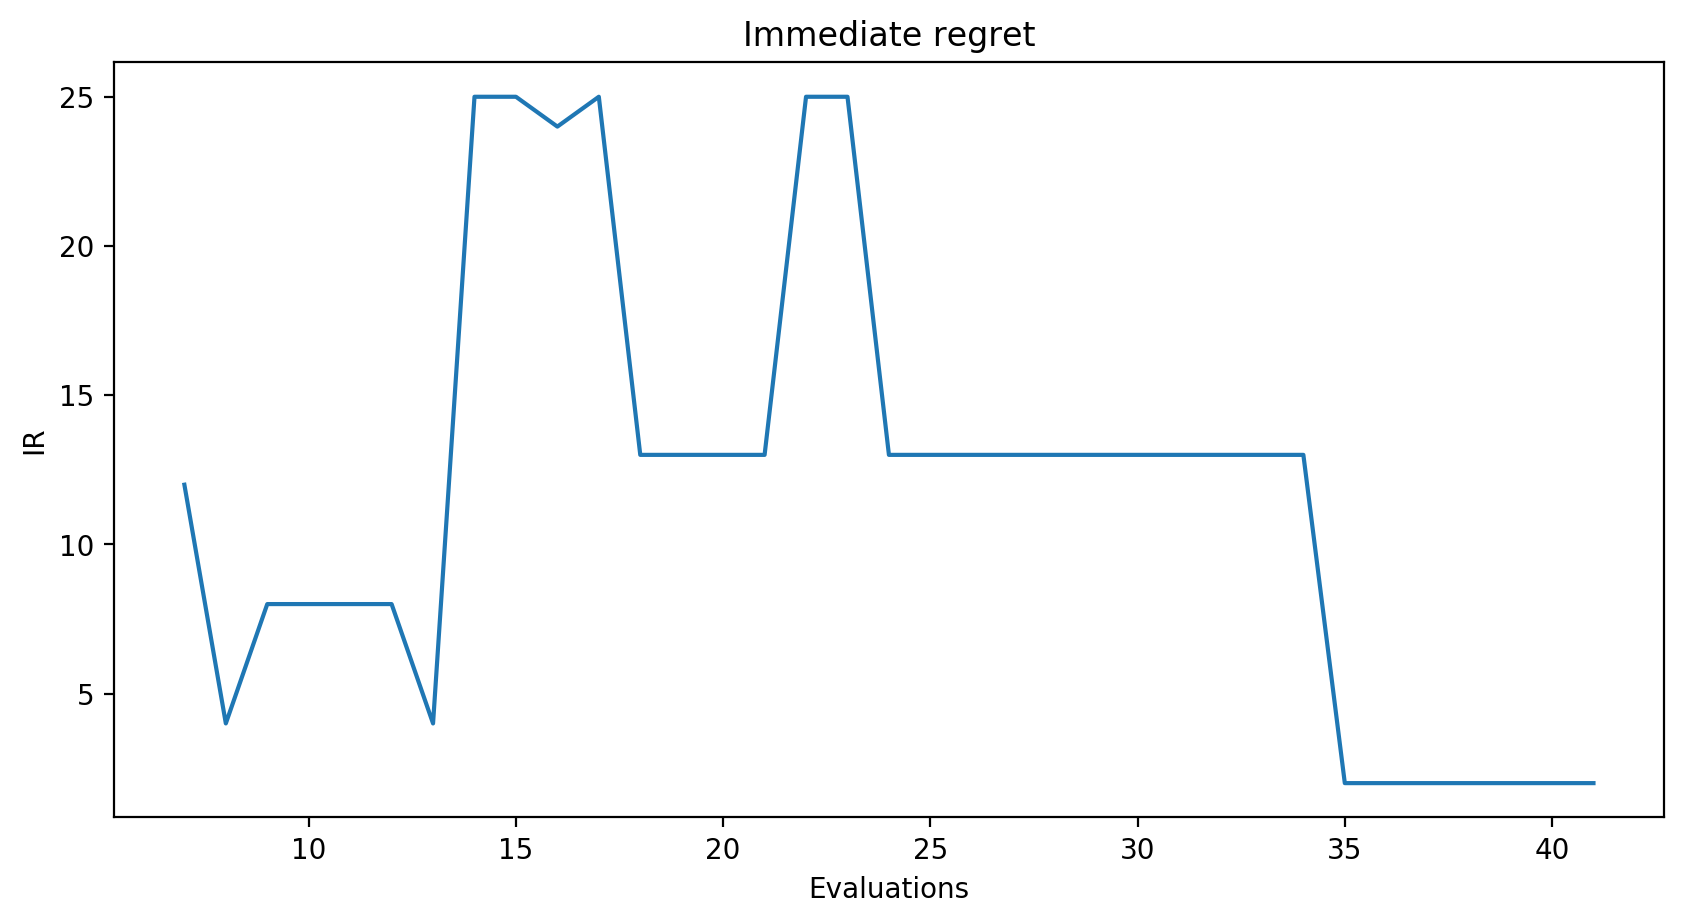

In [131]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(range(7, 42), np.squeeze(immediate_regret))
plt.title("Immediate regret")
plt.xlabel("Evaluations")
plt.ylabel("IR")

Text(0, 0.5, '$x_2$')

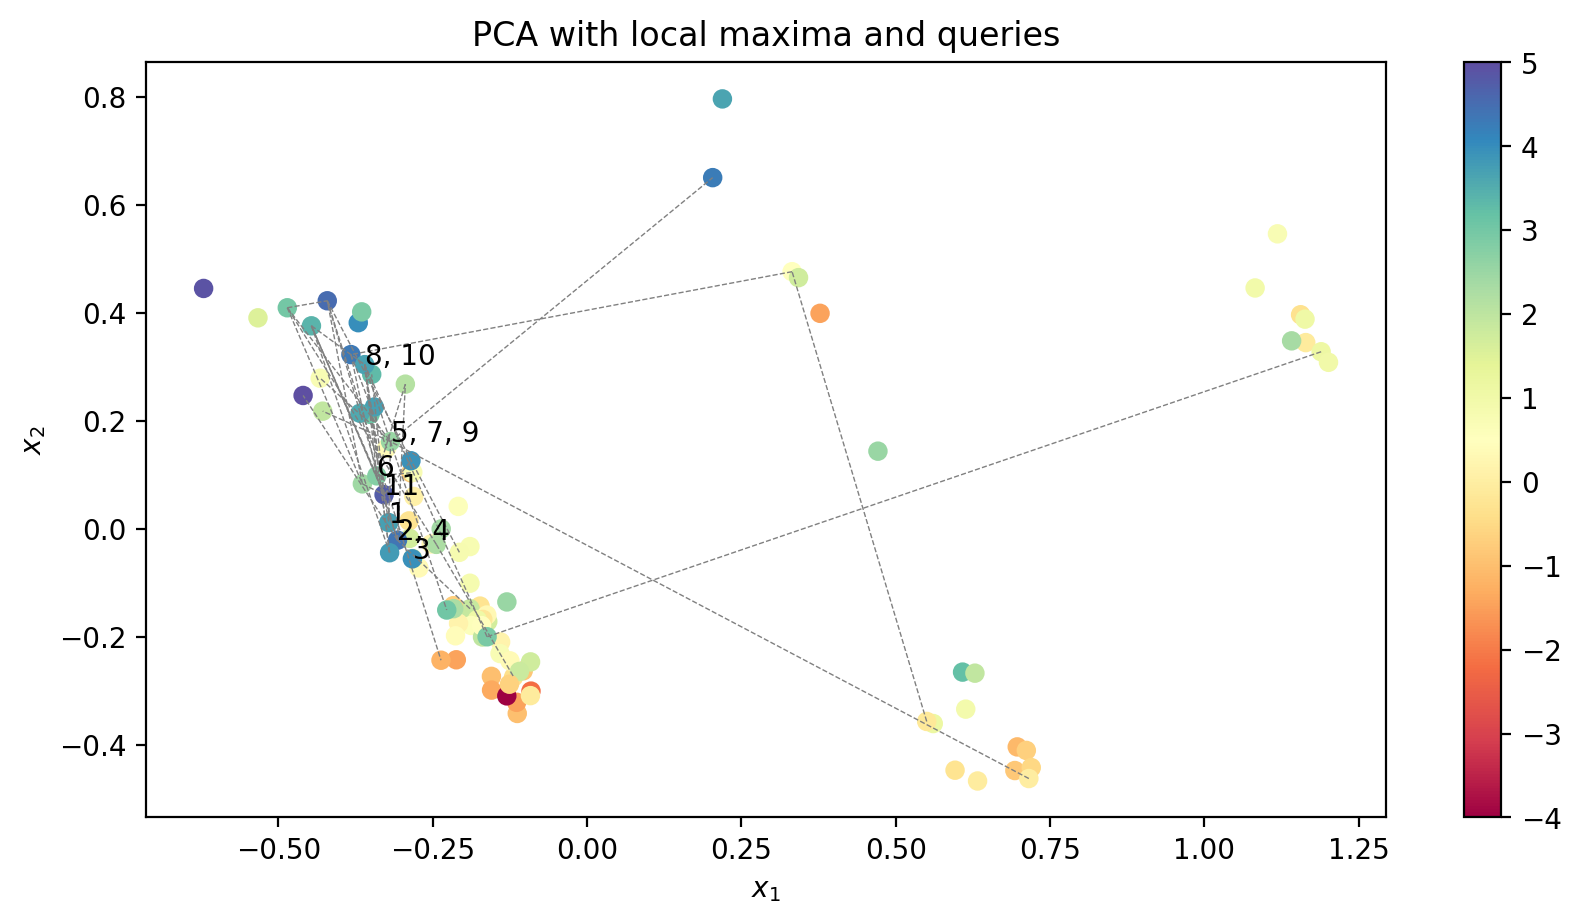

In [132]:
plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(pca_embed[:, 0], pca_embed[:, 1], c=fvals, cmap='Spectral')
for tup in idx_orders_tuples:
    plt.text(pca_embed[tup[0], 0], pca_embed[tup[0], 1], str(tup[1]))
for pair in final:
    x_vals = [pca_embed[pair[0], 0], pca_embed[pair[1], 0]]
    y_vals = [pca_embed[pair[0], 1], pca_embed[pair[1], 1]]
    plt.plot(x_vals, y_vals, linestyle='dashed', linewidth=0.5, color='gray' )
plt.colorbar()
plt.title("PCA with local maxima and queries")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Text(0, 0.5, '$x_2$')

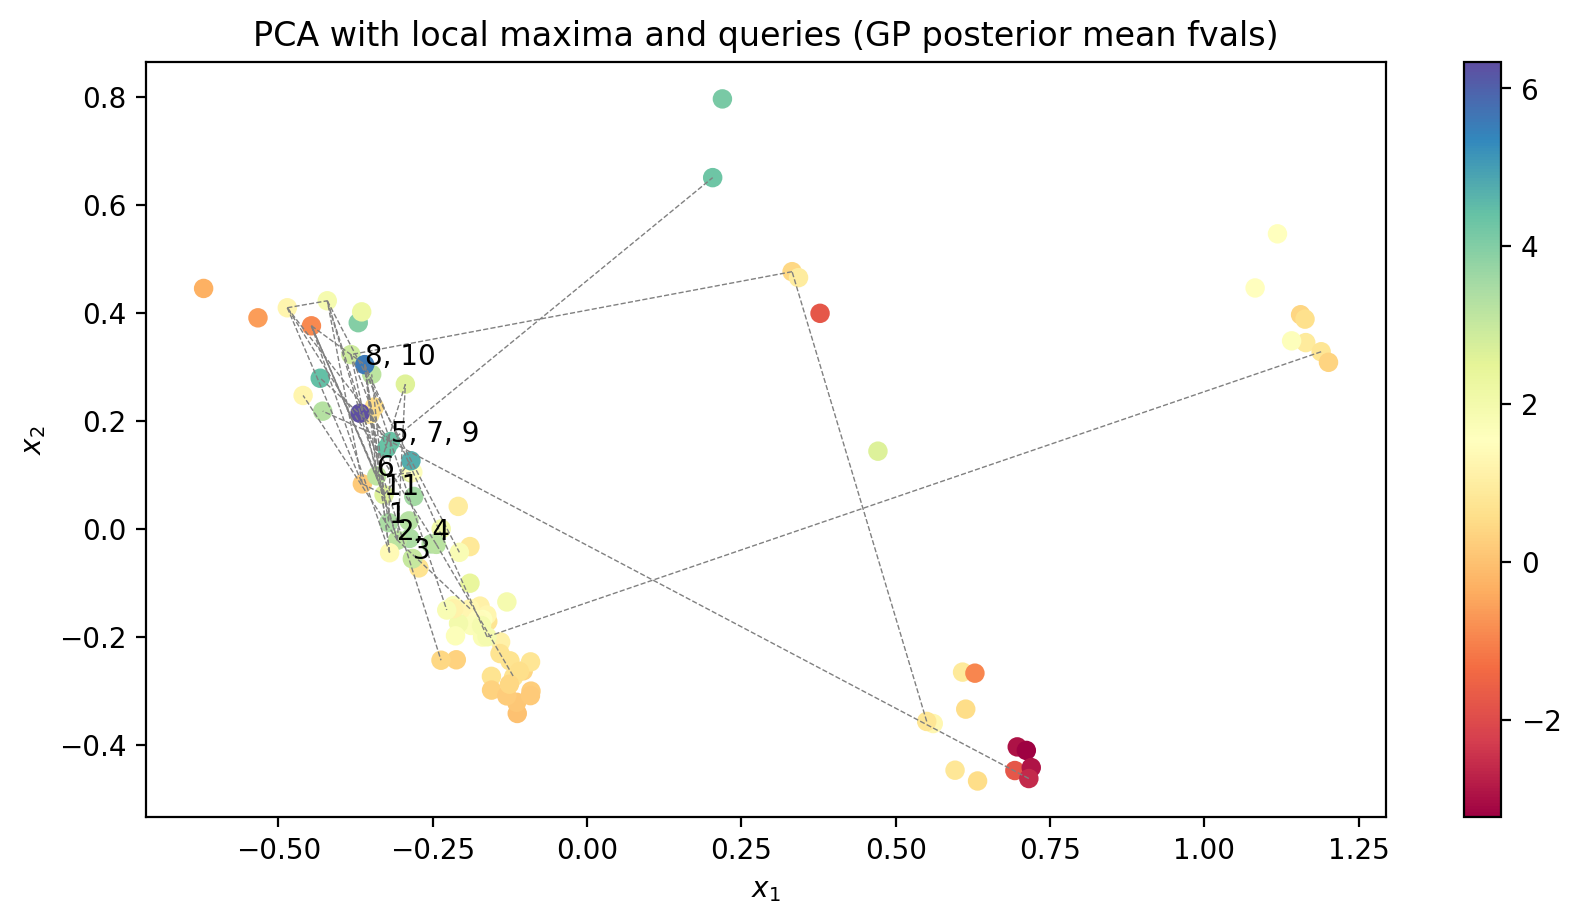

In [195]:
plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(pca_embed[:, 0], pca_embed[:, 1], c=gp_fvals, cmap='Spectral')
for tup in idx_orders_tuples:
    plt.text(pca_embed[tup[0], 0], pca_embed[tup[0], 1], str(tup[1]))
for pair in final:
    x_vals = [pca_embed[pair[0], 0], pca_embed[pair[1], 0]]
    y_vals = [pca_embed[pair[0], 1], pca_embed[pair[1], 1]]
    plt.plot(x_vals, y_vals, linestyle='dashed', linewidth=0.5, color='gray' )
plt.colorbar()
plt.title("PCA with local maxima and queries (GP posterior mean fvals)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [71]:
rank_to_idx_dict = {}
for i in range(len(fval_idx_tuples)):
    rank_to_idx_dict[i+1] = fval_idx_tuples[i][1]

In [72]:
rank_to_idx_dict

{1: 19,
 2: 8,
 3: 37,
 4: 2,
 5: 47,
 6: 9,
 7: 61,
 8: 0,
 9: 79,
 10: 22,
 11: 53,
 12: 15,
 13: 41,
 14: 11,
 15: 26,
 16: 20,
 17: 1,
 18: 10,
 19: 43,
 20: 13,
 21: 76,
 22: 6,
 23: 88,
 24: 3,
 25: 27,
 26: 21,
 27: 57,
 28: 7,
 29: 25,
 30: 31,
 31: 71,
 32: 36,
 33: 73,
 34: 5,
 35: 65,
 36: 45,
 37: 14,
 38: 44,
 39: 96,
 40: 95,
 41: 72,
 42: 34,
 43: 50,
 44: 46,
 45: 4,
 46: 62,
 47: 70,
 48: 54,
 49: 48,
 50: 74,
 51: 38,
 52: 58,
 53: 39,
 54: 32,
 55: 30,
 56: 18,
 57: 29,
 58: 12,
 59: 75,
 60: 23,
 61: 63,
 62: 66,
 63: 67,
 64: 82,
 65: 16,
 66: 35,
 67: 91,
 68: 51,
 69: 33,
 70: 55,
 71: 68,
 72: 24,
 73: 83,
 74: 85,
 75: 98,
 76: 60,
 77: 64,
 78: 52,
 79: 42,
 80: 84,
 81: 28,
 82: 40,
 83: 87,
 84: 80,
 85: 99,
 86: 78,
 87: 49,
 88: 17,
 89: 69,
 90: 77,
 91: 92,
 92: 89,
 93: 56,
 94: 81,
 95: 93,
 96: 94,
 97: 86,
 98: 59,
 99: 90,
 100: 97}

In [73]:
rank_results = immediate_regret + 1

In [74]:
rank_results

array([[13,  5,  9,  9,  9,  9,  5, 26, 26, 25, 26, 14, 14, 14, 14, 26,
        26, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  3,  3,  3,  3,
         3,  3,  3]], dtype=int32)

In [78]:
idx_results = []
for i in range(len(rank_results[0])):
    idx_results.append(rank_to_idx_dict[rank_results[0][i]])

In [79]:
idx_results

[41,
 47,
 79,
 79,
 79,
 79,
 47,
 21,
 21,
 27,
 21,
 11,
 11,
 11,
 11,
 21,
 21,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 37,
 37,
 37,
 37,
 37,
 37,
 37]

In [80]:
idx_to_plot = np.unique(idx_results)

In [81]:
idx_to_plot

array([11, 21, 27, 37, 41, 47, 79])

In [92]:
orders = ["8, 10", "5, 7, 9", "6", "11", "1", "2, 4", "3"]

In [93]:
idx_orders_tuples = list(zip(idx_to_plot, orders))

In [87]:
order = [41, 47, 79, 47, 21, 27, 21, 11, 21, 11, 37]

In [89]:
idx_order_tuples = list(zip(order, range(1, len(order)+1)))

In [197]:
obj_model = gpflow.models.VGP(data=(features, np.expand_dims(fvals, axis=-1)),
                             kernel=gpflow.kernels.RBF(lengthscale=[0.1 for i in range(len(features[0]))]),
                             likelihood=gpflow.likelihoods.Gaussian())

In [198]:
print_summary(obj_model)

name,class,transform,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,True,(),float64,1.0
VGP.kernel.lengthscale,Parameter,Softplus,True,"(6,)",float64,"[0.1, 0.1, 0.1..."
VGP.likelihood.variance,Parameter,Softplus,True,(),float64,1.0
VGP.q_mu,Parameter,,True,"(100, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."


In [199]:
opt = gpflow.optimizers.Scipy()

In [200]:
opt.minimize(lambda: -obj_model.log_likelihood(), obj_model.trainable_variables)

      fun: 137.66047378461906
 hess_inv: <5158x5158 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.97524399e-11, -8.20121228e-14, -9.38537873e-04, ...,
        2.32489324e-05,  5.83602862e-49, -4.41720592e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 600
      nit: 544
   status: 0
  success: True
        x: array([-2.25216845e+00, -2.25216845e+00,  3.83494127e+00, ...,
        2.44041848e-03,  2.98369671e-46,  9.95052240e-01])

In [201]:
print_summary(obj_model)

name,class,transform,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,True,(),float64,13.613666850547077
VGP.kernel.lengthscale,Parameter,Softplus,True,"(6,)",float64,"[0.1, 0.1, 3.85631385..."
VGP.likelihood.variance,Parameter,Softplus,True,(),float64,0.5714791740716392
VGP.q_mu,Parameter,,True,"(100, 1)",float64,[[1.08610138e+00...
VGP.q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[8.06787500e-02, 0.00000000e+00, 0.00000000e+00..."


In [202]:
obj_model.kernel.lengthscale

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.1       , 0.1       , 3.85631385, 0.51266828, 3.15861347,
       2.35291295])>

In [193]:
gp_fvals = np.squeeze(obj_model.predict_f(features)[0])

In [68]:
reducer = umap.UMAP()
umap_embed = reducer.fit_transform(features)

Text(0, 0.5, '$x_2$')

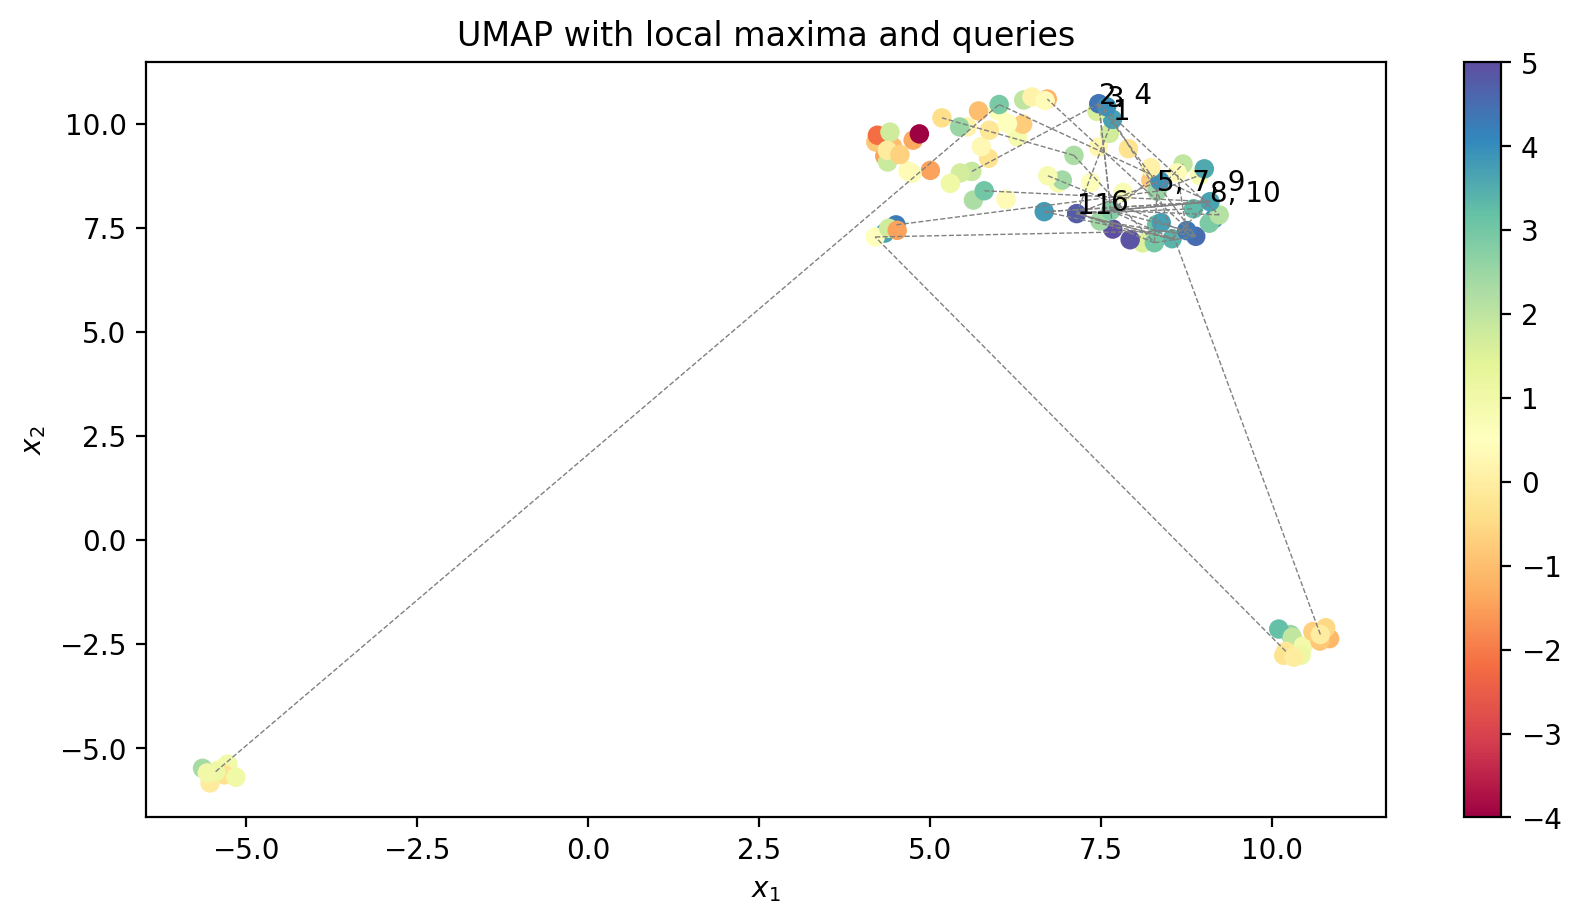

In [133]:
plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=fvals, cmap='Spectral')
for tup in idx_orders_tuples:
    plt.text(umap_embed[tup[0], 0], umap_embed[tup[0], 1], str(tup[1]))
for pair in final:
    x_vals = [umap_embed[pair[0], 0], umap_embed[pair[1], 0]]
    y_vals = [umap_embed[pair[0], 1], umap_embed[pair[1], 1]]
    plt.plot(x_vals, y_vals, linestyle='dashed', linewidth=0.5, color='gray' )
plt.colorbar()
plt.title("UMAP with local maxima and queries")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Text(0, 0.5, '$x_2$')

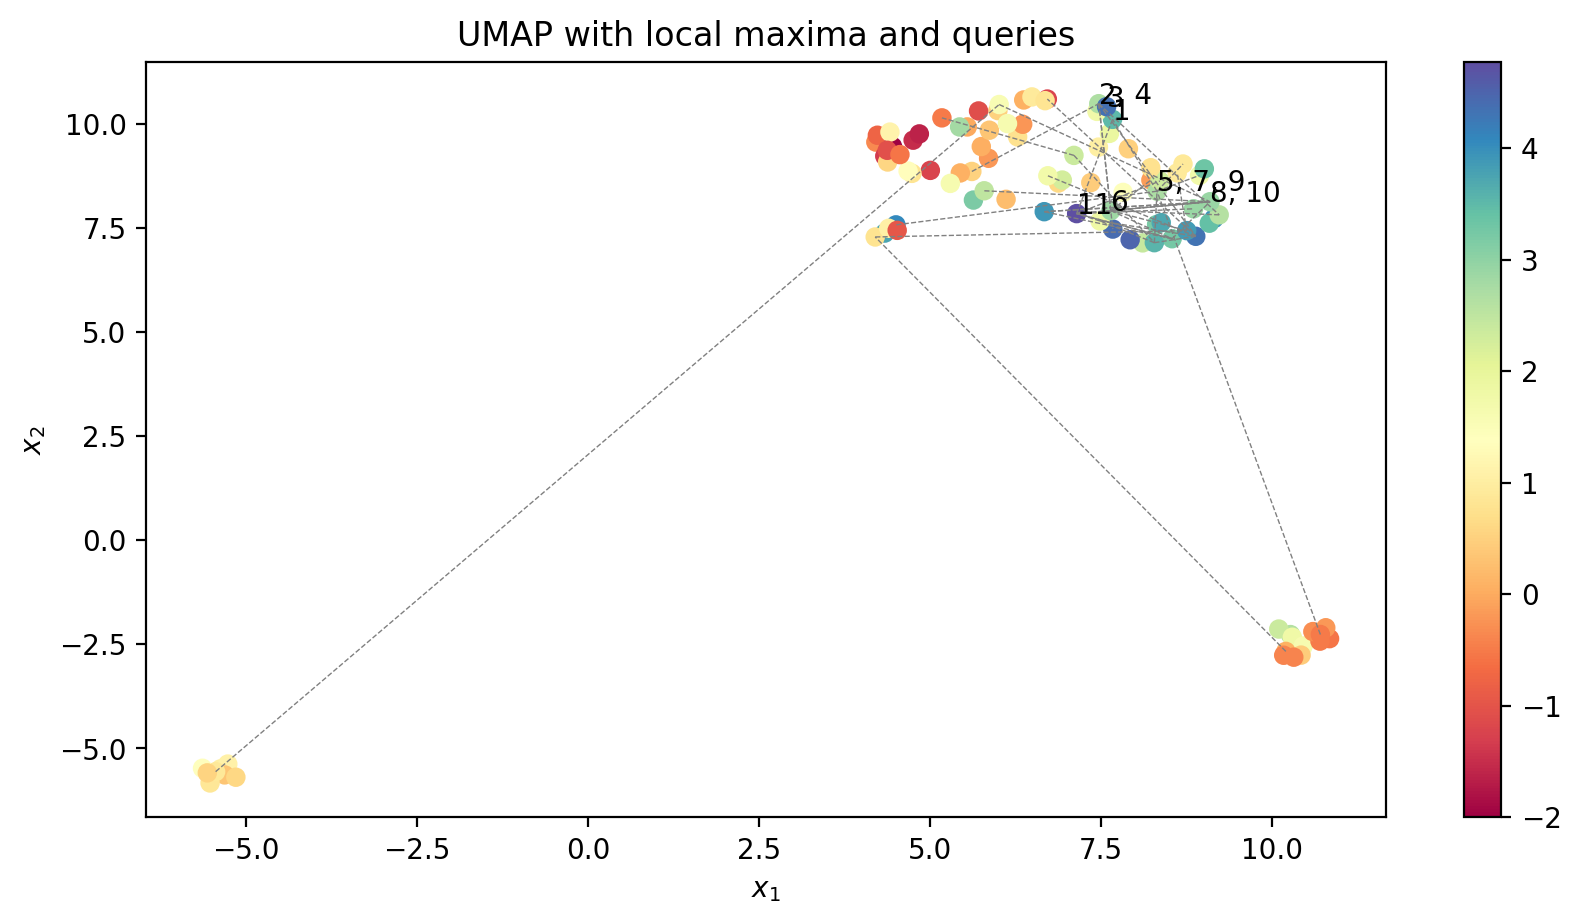

In [172]:
plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=gp_fvals, cmap='Spectral')
for tup in idx_orders_tuples:
    plt.text(umap_embed[tup[0], 0], umap_embed[tup[0], 1], str(tup[1]))
for pair in final:
    x_vals = [umap_embed[pair[0], 0], umap_embed[pair[1], 0]]
    y_vals = [umap_embed[pair[0], 1], umap_embed[pair[1], 1]]
    plt.plot(x_vals, y_vals, linestyle='dashed', linewidth=0.5, color='gray' )
plt.colorbar()
plt.title("UMAP with local maxima and queries")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Feature: 0, Score: 0.34028
Feature: 1, Score: -0.03521
Feature: 2, Score: 0.57940
Feature: 3, Score: 12.36175
Feature: 4, Score: 1.72840
Feature: 5, Score: -2.16737


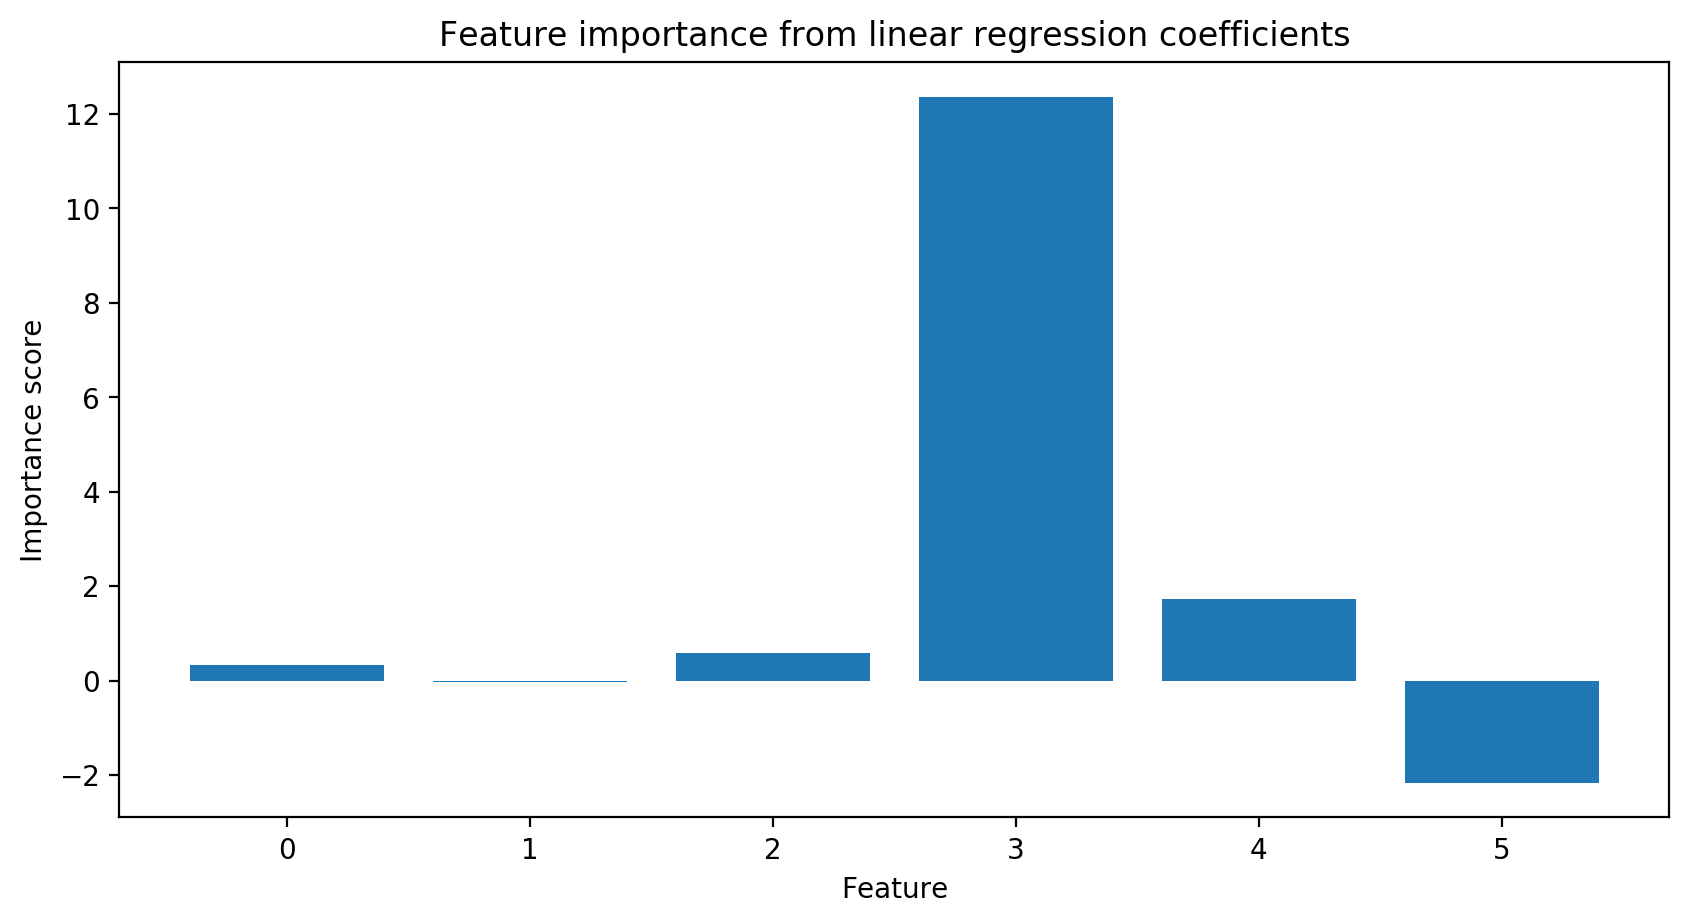

In [135]:
X, y = features, fvals
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(10, 5), dpi=200)
plt.bar([x for x in range(len(importance))], importance)
plt.title("Feature importance from linear regression coefficients")
plt.xlabel("Feature")
plt.ylabel("Importance score")
plt.show()


Text(0.5, 0, '$x_3$')

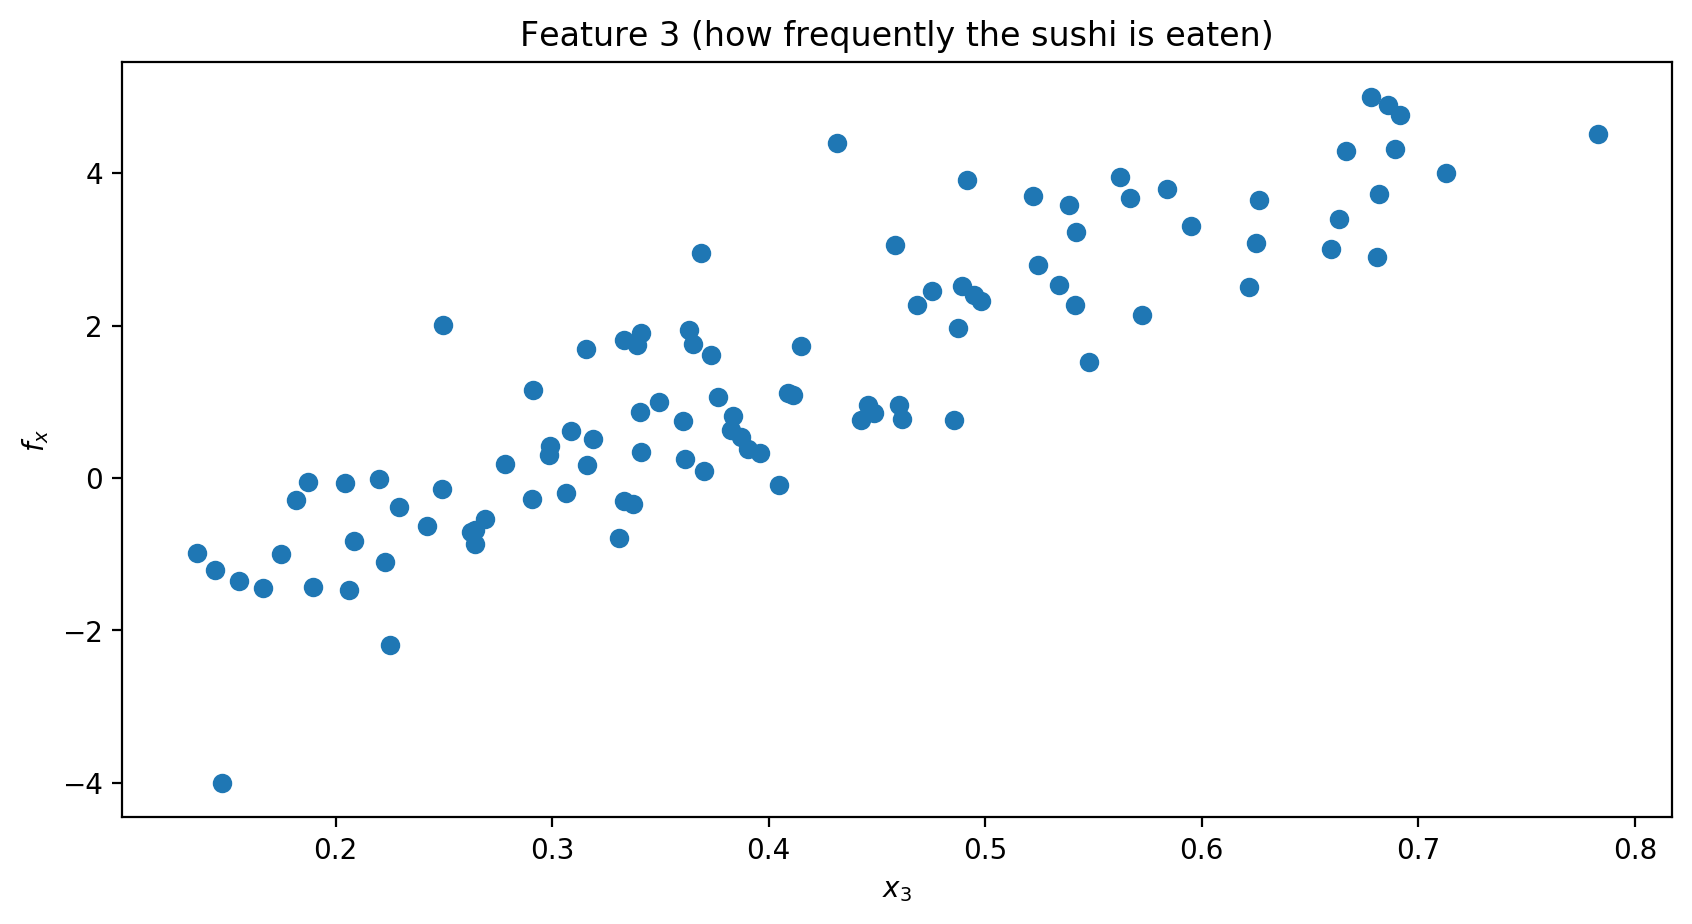

In [138]:
plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(features[:, -3], fvals)
plt.title("Feature 3 (how frequently the sushi is eaten)")
plt.ylabel("$f_x$")
plt.xlabel("$x_3$")